# Projections Experiment

Investigate the difference between different methods for Projecting High-Dimensional data into lower dim space for visualization (can the AutoEncoder) beat everything out?

Will look at: 
- AutoEncoders- of different flavours, try out a linear version (to approximate PCA?) and then test out the affect of more neurons/layers & alternate activations (tanh, swish, sigmoidal, etc.)
- PCA- tried and true changing of the basis of data (linear, orthogonal projection of data into a lower dimensional vector subspace)

In [2]:

import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset     #wraps the "torch.utils.data.Dataset" in a nice iterable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


# Download and Use MNIST 
training_data = MNIST(
    root="../data", #where to download
    train=True, #flag for train or test subset
    download=False, #will download from scratch if True
    transform=ToTensor(), #can specify a pipeline for transforming (also provides a `target_transform` for modifying labels)
)

test_data = MNIST(
    root="../data",
    train=False,
    download=False,
    transform=ToTensor()
)

# Create Dataloader for Combined Set (no need for the split, just analyzing projections)
BATCH_SIZE = 8 #may change depending on learning
dataset = ConcatDataset([training_data, test_data])
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE) 


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [10]:
len(next(iter(data_loader))[1])
batch_items = next(iter(data_loader))
print(batch_items[0].shape, batch_items[1].shape) #shape of batches of data (x, y)


torch.Size([8, 1, 28, 28]) torch.Size([8])


In [22]:
# Convert a Single Data Tensor into a flattened vector
x = dataset.__getitem__(1)[0] #access data for a single value

x = torch.flatten(x)

x.shape


torch.Size([784])

In [3]:
# Convert Whole dataset into a matrix (70000 x 784) dims

data_matrix = [] #slow method of creating data matrix

for instance in dataset:
    x = torch.flatten(instance[0])
    x = x.numpy()
    data_matrix.append(x)

In [12]:
# PCA Class (referenced– https://medium.com/accel-ai/pca-algorithm-tutorial-in-python-93ff19212026)
import numpy as np

np.seterr(all='raise') #experimental to handle nan/inf error (in eigenvec computation)


class PCA:

    def run(self, data, n_components=2):
        #Components=2 is nice default for visualization
        self.n_samples = data.shape[0] #assuming num of instances is on first axis
        self.n_components = n_components

        # Normalize Data (1st step in PCA, center values around mean with unit standard deviation)
        self.standardized_data = self.standardization(data)

        # Compute CoVariance Matrix & Eigenvectors
        covariance_matrix = self.cm() #references the standardized_data under the hood
        eigenvectors = self.eigenvectors(covariance_matrix)

        # Project Standardized Data w Eigenvectors
        projected_data = self.projection(eigenvectors)

        return projected_data

    def standardization(self, data):
        # Scale Data for Unit Std Dev centered around Mean
        data = data + 1e-12 #add epsilon to avoid divide by zero
        z = (data - np.mean(data, axis=0)) / (np.std(data, axis=0)) #computed at row level?
        return z
    
    # Covariance Matrix Func
    def cm(self, degrees_freedom=0):
        covariance_matrix = np.dot(self.standardized_data.T, self.standardized_data) / (self.n_samples-degrees_freedom)
        return covariance_matrix

    def eigenvectors(self, covariance_matrix):
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        n_cols = np.argsort(eigenvalues)[::-1][:self.n_components]
        selected_vecs = eigenvectors[:,n_cols]
        return selected_vecs

    def projection(self, eigenvecs):
        P = np.dot(self.standardized_data, eigenvecs)
        return P


# Driver Code
pca = PCA() #init class, saved in external file 
data_matrix = np.array(data_matrix) #convert list of tensors into a numpy ndarray of correct dim: (70k x 784)
projected_data_matrix = pca.run(data_matrix, 3) #2 for 2d, 3 for 3d (controls dimensions for Principal Components)
labels = np.array([i[1] for i in dataset]) #convert labels from Torch Dataset to a np vector


True


In [13]:
concated_data = np.vstack((projected_data_matrix, labels)).T

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 70000

In [ ]:
# Autoencoder for MNIST

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 10),
            # 10
            nn.Softmax(),
            )
        self.decoder = nn.Sequential(
            # 10
            nn.Linear(10, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


# Training, Loss & Optimizer
distance = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cpu()
        output = model(img)
        loss = distance(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

#### Plot Results

Currently doing it via a simple Matplotlib Scatter, can we do it more elegantly? (perhaps w something like TensorBoard's 3D Visualization Tool?)

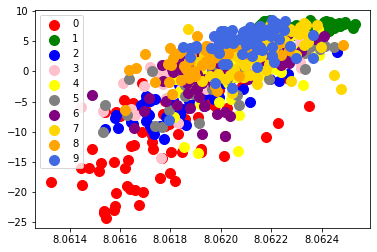

In [16]:
import matplotlib.pyplot as plt 


# Parse Projected Matrix for correct data
n_instances = 700 #number of instances from data to plot (max=70k)
x, y = projected_data_matrix[:n_instances, 0].real, projected_data_matrix[:n_instances, 1].real
n_labels = labels[:n_instances]
cdict = {0 : "red", 1 : "green", 2 : "blue", 3 : "pink", 4 : "yellow", 5 : "grey", 6 : "purple", 7 : "gold", 8 : "orange", 9 : "royalblue"}

fig, ax = plt.subplots()
for g in np.unique(n_labels):
    ix = np.where(n_labels==g)
    ax.scatter(x[ix], y[ix], c=cdict[g], label=g, s=100)
ax.legend()
plt.show()




In [10]:
# Plotly 2D Scatter

import plotly.express as px
df = px.data.iris()
fig = px.scatter(x=x, y=y)
fig.show()

SyntaxError: invalid syntax (543305654.py, line 5)

In [18]:
# Plotly 3D Scatter


x, y, z = projected_data_matrix[:n_instances, 0].real, projected_data_matrix[:n_instances, 1].real, projected_data_matrix[:n_instances, 2].real

df = px.data.iris()
fig = px.scatter_3d(x=x, y=y, z=z)
fig.show()



In [16]:
# Accessing MNIST (Image, Label) pairs through dataset object
dataset.__getitem__(70000-1) #access any instance within a dataset

dataset.__getitem__(1)[0] # X data (tensor describing image)
dataset.__getitem__(1)[1] # y data (label for image class)

0

In [4]:
for i in range(0, 69999):
    instance = dataset.__getitem__(i)
    print(instance[1])

5
0
4
1
9
2
1
3
1
4
3
5
3
6
1
7
2
8
6
9
4
0
9
1
1
2
4
3
2
7
3
8
6
9
0
5
6
0
7
6
1
8
7
9
3
9
8
5
9
3
3
0
7
4
9
8
0
9
4
1
4
4
6
0
4
5
6
1
0
0
1
7
1
6
3
0
2
1
1
7
9
0
2
6
7
8
3
9
0
4
6
7
4
6
8
0
7
8
3
1
5
7
1
7
1
1
6
3
0
2
9
3
1
1
0
4
9
2
0
0
2
0
2
7
1
8
6
4
1
6
3
4
5
9
1
3
3
8
5
4
7
7
4
2
8
5
8
6
7
3
4
6
1
9
9
6
0
3
7
2
8
2
9
4
4
6
4
9
7
0
9
2
9
5
1
5
9
1
2
3
2
3
5
9
1
7
6
2
8
2
2
5
0
7
4
9
7
8
3
2
1
1
8
3
6
1
0
3
1
0
0
1
7
2
7
3
0
4
6
5
2
6
4
7
1
8
9
9
3
0
7
1
0
2
0
3
5
4
6
5
8
6
3
7
5
8
0
9
1
0
3
1
2
2
3
3
6
4
7
5
0
6
2
7
9
8
5
9
2
1
1
4
4
5
6
4
1
2
5
3
9
3
9
0
5
9
6
5
7
4
1
3
4
0
4
8
0
4
3
6
8
7
6
0
9
7
5
7
2
1
1
6
8
9
4
1
5
2
2
9
0
3
9
6
7
2
0
3
5
4
3
6
5
8
9
5
4
7
4
2
7
3
4
8
9
1
9
2
8
7
9
1
8
7
4
1
3
1
1
0
2
3
9
4
9
2
1
6
8
4
7
7
4
4
9
2
5
7
2
4
4
2
1
9
7
2
8
7
6
9
2
2
3
8
1
6
5
1
1
0
2
6
4
5
8
3
1
5
1
9
2
7
4
4
4
8
1
5
8
9
5
6
7
9
9
3
7
0
9
0
6
6
2
3
9
0
7
5
4
8
0
9
4
1
2
8
7
1
2
6
1
0
3
0
1
1
8
2
0
3
9
4
0
5
0
6
1
7
7
8
1
9
2
0
5
1
2
2
7
3
5
4
9
7
1
8
3
9
6
0
3
1
1
2
6
3
5
7
6
8
